In [1]:
import json
import numpy as np
import shutil
import glob
from tqdm import tqdm
import pandas as pd
import unidecode
import os
import subprocess
import  tarfile
import xml.etree.ElementTree as ET
import ast
import zipfile
import datetime

## Filtering with France

In [5]:
os.makedirs('/scratch/students/antoun/figaro_words/france/filtered_france', exist_ok=True)

In [13]:
json_count = 0
filter_count = 0

for root, dirs, files in os.walk('/scratch/students/antoun/corpus/le_figaro'):
    for file_name in files:
        if file_name.endswith('.json'):
            with open(os.path.join(root, file_name)) as json_file:
                json_text = json.load(json_file)
                json_count += 1

                # Check if "France" is in file
                if "France" in json.dumps(json_text):
                    # Read the first three lines of the article
                    with open(os.path.join(root, file_name)) as article_file:
                        article_lines = article_file.readlines()
                    
                    # Check if the article has at least three lines
                    if len(article_lines) >= 3:
                        # Check if "France" is in the third line
                        if "France" in article_lines[2]:
                            # Copy file to filtered file directory
                            shutil.copyfile(os.path.join(root, file_name), os.path.join('/scratch/students/antoun/figaro_words/france/filtered_france', file_name))
                            filter_count += 1

print(f"Found {json_count} JSON files in the directory")
print(f"Found {filter_count} files with the word")


Found 28503 JSON files in the directory
Found 0 files with the word


In [11]:
if not os.path.exists("/scratch/students/antoun/figaro_words/france/data"):
    os.makedirs("/scratch/students/antoun/figaro_words/france/data")

#Get list of all articles
every_article = glob.glob('/scratch/students/antoun/figaro_words/france/filtered_france/*.json')
france_articles = pd.DataFrame(columns=["publication_date", "content"])
dates_fr = set()
for article in tqdm(every_article):
    date = article.split("/")[-1][:10] #ask
    dates_fr.add(date)
    with open(article, 'r') as f:
        data = json.load(f)   
        if "France" in unidecode.unidecode(str.lower(data["contentAsText"][0])):
            france_articles.loc[date] = {"publication_date" : date, "content":data["contentAsText"][0]}
            #length = len(content)
            #avenir_articles.loc[date] = {"publication_date": date, "content": content, "length": length}

            
            
#sort data by publication date
france_articles.sort_values(by = ["publication_date"], inplace =True)

#save the data
france_articles.to_csv("/scratch/students/antoun/figaro_words/france/filtered_france.csv")

# Save dates
with open('/scratch/students/antoun/figaro_words/france/data/dates_fr.txt','w') as f:
    f.write(str(dates_fr))
    
#sort the dates
with open('/scratch/students/antoun/figaro_words/france/data/dates_fr.txt', 'w') as f:
# parse dates as datetime objects and sort them
    dates_fr_sorted = sorted([datetime.datetime.strptime(date, '%Y%m%d.m') for date in dates_fr])
    # convert datetime objects back to strings in the desired format and write them to file
    f.write('\n'.join([date.strftime('%Y%m%d.m') for date in dates_fr_sorted]))
    
# calculate average length of articles
#avg_length = avenir_articles["length"].mean()

# print the result
#print("Average article length:", avg_length)

    

 26%|██████████████▍                                        | 7483/28503 [04:00<11:15, 31.11it/s]


KeyboardInterrupt: 

## Raw frequency of "france"

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv("/scratch/students/antoun/figaro_words/france/filtered_france.csv")
df = df.sort_values(by = "publication_date")

#convert column "piblication_date" from string to date time format
df["publication_date"] = pd.to_datetime(df["publication_date"], format = "%Y%m%d.m").dt.date

#set index to piblication date column
df = df.set_index("publication_date")
x = np.arange(len(df))

#function that counts raw frequency
def count_word_frequency(word, text):
    return text.count(word)

word = "France"
df["frequency"] = df["content"].apply(lambda x: count_word_frequency(word, x))



y = df["frequency"]
degree = 10
coeffs = np.polyfit(x, y, degree)
frequencies_polyfit = np.polyval(coeffs, x)

#plot
plt.figure(figsize=(10,7))
plt.plot(df.index, df["frequency"], label = "Raw frequency")
plt.title("Number of occurences of the word 'France'")
plt.xlabel("date")
plt.ylabel("Occurences of the word 'France' per article")
plt.legend()
plt.show()

TypeError: expected non-empty vector for x

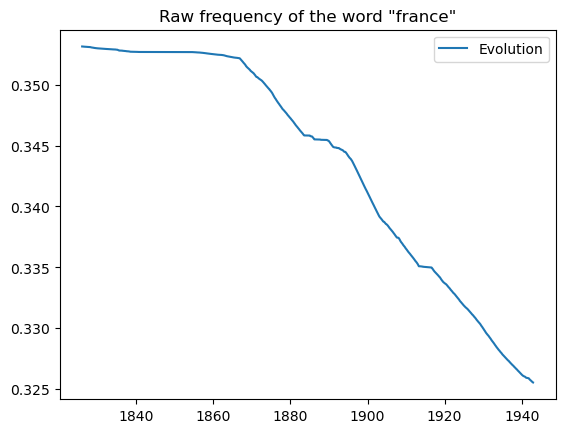

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv("/scratch/students/antoun/figaro_words/france/filtered_france.csv")
df = df.sort_values(by = "publication_date")

#convert column "piblication_date" from string to date time format
df["publication_date"] = pd.to_datetime(df["publication_date"], format = "%Y%m%d.m").dt.date

#set index to piblication date column
df = df.set_index("publication_date")

#function that counts raw frequency
def count_word_frequency(word, text):
    return text.count(word)

word = "france"
df["frequency"] = df["content"].apply(lambda x: count_word_frequency(word, x))



model = LinearRegression()
x = np.arange(len(df)).reshape(-1, 1)
y = df['frequency'].values.reshape(-1, 1)
model.fit(x, y)

plt.plot(df.index, model.predict(x), label = "Linear regression")
plt.title('Raw frequency of the word "France"')
plt.legend()
plt.show()

## Dividing dates into blocks

In [1]:
import nltk 
nltk.download('punkt')
from nltk import ngrams
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

[nltk_data] Downloading package punkt to /home/tamantoun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Load the CSV file into a pandas data frame
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("/scratch/students/antoun/figaro_words/nation/filtered_France.csv")

df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y%m%d.m').dt.date

# Define the date ranges
range0 = (datetime.datetime.strptime('18260101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18401231.m', '%Y%m%d.m').date())

range1 = (datetime.datetime.strptime('18400101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18601231.m', '%Y%m%d.m').date())

range2 = (datetime.datetime.strptime('18600101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18801231.m', '%Y%m%d.m').date())

range3 = (datetime.datetime.strptime('18800101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19001231.m', '%Y%m%d.m').date())

range4 = (datetime.datetime.strptime('19000101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19201231.m', '%Y%m%d.m').date())

# Open the file and read the dates
with open('/scratch/students/antoun/figaro_words/france/data/dates_fr.txt', 'r') as f:
    dates = f.read().splitlines()

# Convert the dates to date objects
dates = [datetime.datetime.strptime(date, '%Y%m%d.m').date() for date in dates]

block0 =  df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range0[0], range0[1])]
new_value0 = block0["content"].apply(nltk.word_tokenize) 
block0.loc[:, "tokens"] =  new_value0

block1 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range1[0], range1[1])]
new_value1 = block1["content"].apply(nltk.word_tokenize) 
block1.loc[:, "tokens"] =  new_value1

block2 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range2[0], range2[1])]
new_value2 = block2["content"].apply(nltk.word_tokenize) 
block2.loc[:, "tokens"] =  new_value2

block3 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range3[0], range3[1])]
new_value3 = block3["content"].apply(nltk.word_tokenize) 
block3.loc[:, "tokens"] =  new_value3

block4 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range4[0], range4[1])]
new_value4 = block4["content"].apply(nltk.word_tokenize) 
block4.loc[:, "tokens"] =  new_value4

# Print the number of dates in each block
print(f"Block 0 ({range0[0]} - {range0[1]}): {len(block0)} dates")
print(f"Block 1 ({range1[0]} - {range1[1]}): {len(block1)} dates")
print(f"Block 2 ({range2[0]} - {range2[1]}): {len(block2)} dates")
print(f"Block 3 ({range3[0]} - {range3[1]}): {len(block3)} dates")
print(f"Block 4 ({range4[0]} - {range4[1]}): {len(block4)} dates")

Block 0 (1826-01-01 - 1840-12-31): 204 dates
Block 1 (1840-01-01 - 1860-12-31): 112 dates
Block 2 (1860-01-01 - 1880-12-31): 2857 dates
Block 3 (1880-01-01 - 1900-12-31): 3384 dates
Block 4 (1900-01-01 - 1920-12-31): 3871 dates


# 2-grams

In [5]:
import string
punctuations = string.punctuation

## Block 1

In [4]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_1_before = []

for doc in block1["tokens"]:
    for i in range(len(doc)):
        if doc[i] == ("france"):
            if i > 1:
                two_grams_block_1_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_1_before = FreqDist(two_grams_block_1_before)


with open("/scratch/students/antoun/figaro_words/france/texts/france_before1.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_1-----------------------Two-grams before 'france':\n")
    for two_gram in two_grams_block_1_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 1 (1840-1860): \n")
print(f"2-grams before 'france': \n")
print(two_grams_block_1_before, "\n")

print("Most common 2-grams before 'france': \n")
print(freq_dist_block_1_before.most_common(), "\n")



Block 1 (1840-1860): 

2-grams before 'france': 

[] 

Most common 2-grams before 'france': 

[] 



In [18]:
two_grams_block_1_after = []

for doc in block1["tokens"]:
    for i in range(len(doc)):
        if doc[i] == ("france"):
            if i < len(doc)-3:
                two_grams_block_1_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_1_after = FreqDist(two_grams_block_1_after)

with open("/scratch/students/antoun/figaro_words/france/texts/france_after1.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_1-----------------------Two-grams after 'france':\n")
    for two_gram in two_grams_block_1_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'france': \n")
print(two_grams_block_1_after, "\n")

print("Most common 2-grams after 'france': \n")
print(freq_dist_block_1_after.most_common())

2-grams after 'france': 

[] 

Most common 2-grams after 'france': 

[]


## Block 2

In [6]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_2_before = []

for doc in block2["tokens"]:
    for i in range(len(doc)):
        if doc[i] == ("France"):
            if i > 1:
                two_grams_block_2_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_2_before = FreqDist(two_grams_block_2_before)


with open("/scratch/students/antoun/figaro_words/france/texts/france_before2.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_2-----------------------Two-grams before france':\n")
    for two_gram in two_grams_block_2_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 2 (1860-1880): \n")
print(f"2-grams before 'France': \n")
print(two_grams_block_2_before, "\n")

print("Most common 2-grams before 'france': \n")
print(freq_dist_block_2_before.most_common(), "\n")




Block 2 (1860-1880): 

2-grams before 'France': 

[('éminents', 'de'), ('Gazette', 'de'), ('Gazette', 'de'), ('toute', 'la'), ('berceau', 'la'), ('ignorer', 'en'), ('semble', "qu'en"), ('sur', 'la'), ('fils', 'de'), ('de', 'la'), ('«', 'la'), ('comme', 'en'), ('à', 'la'), ('de', 'la'), ('de', 'la'), (',', 'en'), ('de', 'la'), ('pour', 'la'), ('Quitte', 'la'), ('Gazette', 'de'), ('plaindre', 'de'), ('de', 'la'), ('collège', 'de'), ('villes', 'de'), ('doutaient', 'en'), ('venir', 'en'), ('et', 'en'), ('que', 'la'), ('défendre', 'la'), ('par', 'la'), ('Gazette', 'de'), ('par', 'la'), ('miirmu-er-l', 'Ltf'), (',', 'la'), ('voyagé', 'de'), ('de', 'la'), ('parle', 'en'), ('liberté', 'en'), ('faire', 'en'), ('.', 'En'), (',', 'la'), ('*', 'de'), ('maréchal', 'de'), ('à', 'la'), (';', 'en'), ('rois', 'de'), ('rois', 'de'), ('que', 'la'), ('de', 'la'), ('noblesse', 'de'), ("l'écho", 'en'), ('de', 'la'), ('occupé', 'la'), ('pas', 'la'), ('RIMÉE', 'La'), ('envahit', 'la'), (',', 'la'), ('laisse',

In [7]:
two_grams_block_2_after = []

for doc in block2["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("France"):
            if i < len(doc)-3:
                two_grams_block_2_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_2_after = FreqDist(two_grams_block_2_after)

with open("/scratch/students/antoun/figaro_words/france/texts/france_after2.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_2-----------------------Two-grams after 'france':\n")
    for two_gram in two_grams_block_2_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'france': \n")
print(two_grams_block_2_after, "\n")

print("Most common 2-grams after 'france': \n")
print(freq_dist_block_2_after.most_common())

2-grams after 'france': 

[("d'Angleterre", 'et'), ('qui', 'se'), ('me', 'paraît'), ('a', 'consacré'), ('diamant', '»'), ('Le', 'Non'), ("lorsqu'il", "s'agit"), ('depuis', 'soixante'), ('soutenue', 'par'), ('pour', 'jeter'), ('est', 'assez'), ('M.', 'Obin'), ('Lo', 'Figaro'), ('plus', 'tard'), ('conserva', 'toujours'), ('comme', 'un'), ('et', 'tantôt'), ('Le', 'juste-au-corps'), ('pour', "l'Espagne"), ('de', 'son'), ('et', 'de'), ('où', 'chacun'), ('et', "qu'il"), ('en', 'général'), ('ni', 'les'), ('se', 'montre'), ('On', 'criait'), ('allait', "s'écrouler"), ('envahie', 'du'), ('au', 'Sud'), ('a', "l'Est"), ('—', 'de'), ('elle-même', '■'), ('et', 'le'), ('en', 'Angleterre'), ('se', 'dècidera-t-elle'), ('un', 'bien'), ('pour', 'les'), ('le', 'commis-'), ('où', "l'on"), ('attend', 'encore'), ('est', 'pire'), ('et-', 'vous-'), ('exigent', 'que'), ('la', 'Persiani'), ('mais', 'les'), ('étaient', 'plus'), ('doit', "l'éclatant"), ('Grâce', 'à'), ('au', 'rôle'), ('quand', 'on'), ('étendu', 'l

## Block 3

In [8]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_3_before = []

for doc in block3["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("France"):
            if i > 1:
                two_grams_block_3_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_3_before = FreqDist(two_grams_block_3_before)


with open("/scratch/students/antoun/figaro_words/france/texts/france_before3.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_3-----------------------Two-grams before 'france':\n")
    for two_gram in two_grams_block_3_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 3 (1880-1900): \n")
print(f"2-grams before 'france': \n")
print(two_grams_block_3_before, "\n")

print("Most common 2-grams before 'france': \n")
print(freq_dist_block_3_before.most_common(), "\n")





Block 3 (1880-1900): 

2-grams before 'france': 

[('à', 'la'), ('maréchal', 'de'), ('maison', 'de'), ('mène', 'en'), ("l'Europe", 'En'), ('ambassadeur', 'de'), ('avec', 'la'), ('pour', 'la'), ('Berlin', 'la'), ('s—', 'En'), ('ambassadeur', 'de'), ('do', "l'ancienne"), ('Vhistoire', 'de'), ('Histoire', 'de'), ("d'Espagne", 'en'), ('consul', 'de'), ('pair', 'de'), ('pair', 'de'), ('maréchal', 'de'), ('à', 'la'), ('inquiétude', 'En'), ('loterie', 'en'), ('«', 'La'), ('nuageux', 'La'), ('villes', 'de'), ('synagogues', 'dè'), ('Norvège', 'En'), ('Gazette', 'de'), ('Yacht-Club', 'de'), ('platond', 'La'), ('de', 'la'), ('a', 'en'), ('sociale', 'Notre'), ('de', 'la'), ('M.', 'Anatole'), ('de', 'la'), ("l'histoire", "del'ancienne"), ('truire', 'en'), ('de', 'la'), ('de', 'la'), ('de', 'la'), ('de', 'la'), ('ambassadeur', 'de'), ('violons', 'en'), ("l'histoire", 'de'), ('roines', 'de'), ('nuages', 'En'), ('de-', 'la'), ('tracté', 'en'), ('sur', 'la'), ('que', 'la'), ('de', 'la'), ('terrible', '

In [9]:
two_grams_block_3_after = []

for doc in block3["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("France"):
            if i < len(doc)-3:
                two_grams_block_3_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_3_after = FreqDist(two_grams_block_3_after)

with open("/scratch/students/antoun/figaro_words/france/texts/france_after3.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_3-----------------------Two-grams after france':\n")
    for two_gram in two_grams_block_3_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'france': \n")
print(two_grams_block_3_after, "\n")

print("Most common 2-grams after 'france': \n")
print(freq_dist_block_3_after.most_common())

2-grams after 'france': 

[("c'était", 'la'), ('et', "l'épée"), ('déta', 'chant'), ('=-', 'Les'), ('le', 'thermomètre'), ('à', 'Berlin'), ('M.', 'de'), ('Il', 'dépend'), ('dit', "qu'il"), ('la', 'température'), ('à', 'Berlin'), ('de', "l'Echo"), ('est', 'due'), ("l'Histoire", 'de'), ('en', 'ce'), ('il', 'Turin'), ('par', 'Louis'), ('aux', 'Français'), ('me', 'ra'), ('ou', 'préside-t-il'), ('depuis', 'Louis'), ('puisque', "c'est"), ('est', 'centre'), ('va', 'jusqu'), ('se', 'partageront'), ('puis', 'pour'), ('le', 'frpid'), ('assistaient', "'au"), ('se', 'compose'), ('politique', 'qui'), ('vis-à-vis', 'de'), ("l'immense", 'majo'), ('chasser^tôt', 'ou'), ('Sûr', 'lçs'), ('aurait', 'été'), ('contemporaine', 'sans'), ('sans', 'se'), ('tout', 'gouvernement'), ('contemporaine', 'est'), ('que', 'pour'), ('e', 't'), ('à', 'l'), ('à', 'Berlin'), ('moins', 'encore'), ('un', 'monde'), ('à', 'côté'), ('le', 'froid'), ('depuis', 'VAgricul'), ('sous', "l'empire"), ('Il', 'a'), ('à', 'perdu'), ('enti

## Block 4

In [11]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_4_before = []

for doc in block4["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("France"):
            if i > 1:
                two_grams_block_4_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_4_before = FreqDist(two_grams_block_4_before)


with open("/scratch/students/antoun/figaro_words/france/texts/france_before4.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_4-----------------------Two-grams before 'france':\n")
    for two_gram in two_grams_block_4_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 4 (1900-1920): \n")
print(f"2-grams before 'france': \n")
print(two_grams_block_4_before, "\n")

print("Most common 2-grams before 'france': \n")
print(freq_dist_block_4_before.most_common(), "\n")

Block 4 (1900-1920): 

2-grams before 'france': 

[('î', 'de'), ('élevée', "qu'en"), ('venir', 'de'), ('si', 'en'), ('tombées', 'en'), ('servi', 'la'), ('tomob.ile-Club', 'de'), ("l'Àutomobile-Club", 'de'), ('notre', 'confrère.la'), ('Posta', 'de'), ('chemin', 'de'), ('laissé', 'en'), ('passe', 'en'), ('à', 'la'), ('hors', 'de'), ('montrera', 'la'), ('auquel', 'la'), ('de', 'la'), ('de', 'la'), ('pour', 'la'), ('Poste', 'de'), ('fait', 'Anatole'), ('Moscou', 'En'), ('Steeple-Choses', 'de'), ('changé', 'en'), ('Poste', 'de'), ('de', 'la'), ('»', 'La'), ('Steeple-Chases', 'de'), ('de', 'la'), ('Agriculteurs', 'de'), ('Femmes', 'de'), ('Femmes', 'de'), ('ici', "qu'en"), ('-■■■-', 'de'), ('hors', 'de'), ('quelconque', 'de'), ('Vive', 'la'), ('Vive', 'la'), ('Vive', 'la'), ('Poste', 'de'), ('impopulaire', 'en'), ('passé', 'en'), ('venir', 'en'), ('combattu', 'la'), ('Vive', 'la'), ('pour', 'la'), ('hors', 'de'), ('toujours', 'une'), ('mettent', 'la'), ('baisse', 'En'), ('Moscou', 'En'), ('P

In [10]:
two_grams_block_4_after = []

for doc in block4["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("France"):
            if i < len(doc)-3:
                two_grams_block_4_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_4_after = FreqDist(two_grams_block_4_after)

with open("/scratch/students/antoun/figaro_words/france/texts/france_after4.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_4-----------------------Two-grams after 'france':\n")
    for two_gram in two_grams_block_4_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'france': \n")
print(two_grams_block_4_after, "\n")

print("Most common 2-grams after 'france': \n")
print(freq_dist_block_4_after.most_common())

2-grams after 'france': 

[('et', "d'Algérie"), ('puis', 'les'), ('un', 'frère'), ('quelques', 'efforts'), ('au', 'Mans'), ('sous', 'trois'), ('un', 'certain'), ('poiir', 'prouver'), ('automobile', 'pour'), ('et', "d'Algérie"), ('et', 'par'), ('une', 'famille'), ('ne', 'vous'), ('...', "L'excellent"), ('...', 'Le'), ('une', 'fois'), ('nous', 'convie'), ('il', 'rne'), ('im\\', '«'), ('des', 'vœux'), ('et', "d'Algérie"), ('Échos', 'La'), ('il', "n'est"), ('Sultan', 'IL'), ('...', 'que'), ('et', "d'Algérie"), ('vis-à-vis', 'de'), ('n', 'a'), ('Sultan', 'II'), ('et', 'des'), ("l'assemblée", 'générale'), ('vient', '^accepter'), ('sous', 'la'), ('sur', 'la'), ('et', "d'Algérie"), ('Ge', 'matin'), ('La', 'loi'), ('Mais', 'sans'), ('l', 'Quelques'), ('i', 'Vive'), ('et', "d'Algérie"), ('...', 'M.'), ('depuis', 'trente'), ('il', 'ne'), ('dans', 'le'), ('et', 'vive'), ('...', 'Dans'), ('comme', 'ils'), ('il', 'y'), ('au-dessus', 'de'), ('on', 'signale'), ('des', 'averses'), ('et', "d'Algérie"), 

## Key word in context

In [12]:
from nltk.text import Text

# Create a list of token strings for each block
block1_tokens = [token for doc in block1["tokens"] for token in doc]

# Create a Text object for each block
text_block_1 = Text(block1_tokens)



with open("/scratch/students/antoun/figaro_words/france/texts/key-word-in-context-France_block1.txt ", "w") as file :
    file.write("----------------------BLOCK-1-------------------------- \n")
    for line in text_block_1.concordance_list("France"):
        file.write(line.line + "\n")


# Perform a concordance analysis for the word "France" in each block
print("Concordance analysis for 'France' in Block 1:")
text_block_1.concordance("France")

Concordance analysis for 'France' in Block 1:
Displaying 25 of 83 matches:
 — tel wiélé^ ; rat qui a occupé la France pendant trois mois n'obtiendrait ïm
t , pendant huit jours entiers , la France n'eut ( pas 'd'autre préoccupation 
ef des établissements ' thermaux de France , tandis queM.Pellegrini , un archi
par le récit du Tartare et comme en France , on a de l'esprit depuis le salon 
et : —Premier faiseur de griffes de France ! —d'Henri Nicolle : — il est petit
Ce n'est pas que l'esprit manque en France — il court les rues , — mais il cou
que ; dans ce conflit d'idées où la France est en gagée de- puis plus d'un dem
 ! . , il veut donc devenir pair de France ! ... Je vous donne ma démission ! 
d , M. de * * * était nommé pair de France ; — et , le mystérieux M. Mocquard 
 chocs immenses . « Dieu protège la France , » tel doit être le cri de tous le
 et toute arrière-pensée : — Que la France soit forte , qu'elle soit grande , 
me une chose bien glorieuse pour la France , mais comme 

In [13]:
block2_tokens = [token for doc in block2["tokens"] for token in doc]

text_block_2 = Text(block2_tokens)

with open("/scratch/students/antoun/figaro_words/france/texts/key-word-in-context-France_block2.txt ", "w") as file :
    file.write("----------------------BLOCK-2-------------------------- \n")
    for line in text_block_2.concordance_list("France"):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'France' in Block 2:")
text_block_2.concordance("France")


Concordance analysis for 'France' in Block 2:
Displaying 25 of 11934 matches:
es leshomm .es les plus éminents de France , d'Angleterre et d'Allemagne . Tou
 il a bien fait , car la Gazette de France , qui se plaignait de ne l'avoir vu
cours , M. Janicot de la Gazette de France me paraît avoir in contestablement 
cès qui a occupé récemment toute la France , a consacré , sous l'inspiration d
quier ; » Ayant pour son berceau la France , diamant » Des autres nations dans
un art que nous semblons ignorer en France . Le Non erat hic locus est une règ
 du Conservatoire . Il semble qu'en France , lorsqu'il s'agit d'art , de mu si
Les souverains qui ont régné sur la France , depuis soixante ans , sont presqu
; , le . char funèbre . des fils de France , soutenue par des génies ; le chev
 . On vint de tous les points de la France pour jeter de l'eau bénite sur le c
rt . Le prix n ' y fait'rien ; « la France est assez riche pour payer sa gloir
nien était perdu en Italie comme en France ? M. Obin

In [14]:
block3_tokens = [token for doc in block3["tokens"] for token in doc]

text_block_3 = Text(block3_tokens)

with open("/scratch/students/antoun/figaro_words/france/texts/key-word-in-context-France_block3.txt ", "w") as file :
    file.write("----------------------BLOCK-3-------------------------- \n")
    for line in text_block_3.concordance_list("France"):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'France' in Block 3:")
text_block_3.concordance("France")


Concordance analysis for 'France' in Block 3:
Displaying 25 of 22897 matches:
s.- / C ' e qu'ils demandaient à la France , c'était la patrie . Ils voulaient
par e glorieux bâton de maréchal de France et l'épée du général commandant » à
, avec les armoiries delà maison de France , déta chant leur écusson d'azur su
e de château telle qu'on la mène en France . =- Les invités arrivent . le same
nvahi peu à peu toute l'Europe . En France , le thermomètre , quoique ayant ba
lemel - Lacour comme ambassadeur de France à Berlin est ar rêtée en principe .
s étrangers pour bien vivre avec la France . M. de Freycinet paraît décidé à r
 bon vouloir des puissances pour la France . Il dépend aujourd'hui du gouverne
aire de l'am bassade de Berlin , la France dit qu'il n'est pas encore désigné 
qu'ail Conseil d_es ministr & s— En France , la température , déjà partout en 
 M. Ghallemel-Lacour ambassadeur de France à Berlin , il s'est assuré un long 
 ainsi dire la fusion do l'ancienne France , de l'Ec

In [15]:
block4_tokens = [token for doc in block4["tokens"] for token in doc]

text_block_4 = Text(block4_tokens)

with open("/scratch/students/antoun/figaro_words/france/texts/key-word-in-context-France_block4.txt ", "w") as file :
    file.write("----------------------BLOCK-4-------------------------- \n")
    for line in text_block_4.concordance_list("France", lines=727):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'France' in Block 4:")
text_block_4.concordance("France")


Concordance analysis for 'France' in Block 4:
Displaying 25 of 28153 matches:
 les Bureaux de Poste -■ , ■ î ^ de France et d'Algérie .. -L r -_i ! jssjg~n 
lonies , beaucoup plus élevée qu'en France ; puis les boutiques , ' les cafés 
 de la seconde , il a fait venir de France un frère pour l'aider .. A eux deux
ait là qu'un projet , t > u si , en France quelques efforts , en- .couragés pa
 cessé ; des pluies sont tombées en France , au Mans ; à Nantes , au Havre et 
 , ui ; s'en va , , il a • servi la France sous , trois rois , un , emperëm ? 
 lauriers del'Au- tomob.ile-Club de France , un certain nombre de . nos sports
ême temps -que l'Àutomobile-Club de France , poiir prouver aux ennemis et aux 
ue , .qu'organise notre confrère.la France automobile , pour ! le . 18. févrie
e dans tous les Bureaux de Posta de France et d'Algérie . ce n < ? ' '' t • ''
rs le Sahara une sorte de chemin de France , et . par d'inhospitalières région
z que ces braves gens ont laissé en France une famil